In [14]:
!pip install timm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.4/2.4 MB 52.5 MB/s eta 0:00:0000:01


In [15]:
import torch
from torchvision import transforms
from PIL import Image
import argparse
import matplotlib.pyplot as plt
import numpy as np
from skimage.metrics import peak_signal_noise_ratio
from models import HiddenEncoder, HiddenDecoder, EncoderWithJND, EncoderDecoder
from attenuations import JND

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Helper functions to convert between boolean message arrays and bit strings
def msg2str(msg):
    return "".join(['1' if el else '0' for el in msg])

def str2msg(s):
    return [True if el == '1' else False for el in s]

# Parameters class
class Params():
    def __init__(self, encoder_depth: int, encoder_channels: int, decoder_depth: int, decoder_channels: int, num_bits: int,
                 attenuation: str, scale_channels: bool, scaling_i: float, scaling_w: float):
        # Encoder and decoder parameters
        self.encoder_depth = encoder_depth
        self.encoder_channels = encoder_channels
        self.decoder_depth = decoder_depth
        self.decoder_channels = decoder_channels
        self.num_bits = num_bits
        # Attenuation parameters
        self.attenuation = attenuation
        self.scale_channels = scale_channels
        self.scaling_i = scaling_i
        self.scaling_w = scaling_w

# Define image transforms (using ImageNet normalization)
NORMALIZE_IMAGENET = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                            std=[0.229, 0.224, 0.225])
UNNORMALIZE_IMAGENET = transforms.Normalize(mean=[-0.485/0.229, -0.456/0.224, -0.406/0.225],
                                              std=[1/0.229, 1/0.224, 1/0.225])
default_transform = transforms.Compose([
    transforms.ToTensor(),
    NORMALIZE_IMAGENET
])

# Set up parameters
params = Params(
    encoder_depth=4, encoder_channels=64, decoder_depth=8, decoder_channels=64, num_bits=48,
    attenuation="jnd", scale_channels=False, scaling_i=1, scaling_w=1.5
)

# Create encoder and decoder models
decoder = HiddenDecoder(
    num_blocks=params.decoder_depth, 
    num_bits=params.num_bits, 
    channels=params.decoder_channels
)
encoder = HiddenEncoder(
    num_blocks=params.encoder_depth, 
    num_bits=params.num_bits, 
    channels=params.encoder_channels
)
attenuation = JND(preprocess=UNNORMALIZE_IMAGENET) if params.attenuation == "jnd" else None
encoder_with_jnd = EncoderWithJND(
    encoder, attenuation, params.scale_channels, params.scaling_i, params.scaling_w
)

# Move encoder and decoder to device
encoder_with_jnd = encoder_with_jnd.to(device).eval()
decoder = decoder.to(device).eval()

# Function to load a decoder from a checkpoint
def load_decoder(ckpt_path, decoder_depth, num_bits, decoder_channels, device):
    """Loads the HiddenDecoder model with weights from a checkpoint."""
    decoder_model = HiddenDecoder(num_blocks=decoder_depth, num_bits=num_bits, channels=decoder_channels)
    state_dict = torch.load(ckpt_path, map_location=device)['encoder_decoder']
    # Remove any "module." prefixes if present
    encoder_decoder_state_dict = {k.replace('module.', ''): v for k, v in state_dict.items()}
    decoder_state_dict = {k.replace('decoder.', ''): v 
                          for k, v in encoder_decoder_state_dict.items() if 'decoder' in k}
    decoder_model.load_state_dict(decoder_state_dict)
    decoder_model = decoder_model.to(device).eval()
    return decoder_model

# Function to detect watermark from an image using the decoder model
def detect_watermark(image_path, ckpt_path, decoder_depth=8, num_bits=48, decoder_channels=64):
    """Detects and returns the watermark bits hidden in the image."""
    # Load watermarked image and resize to expected dimensions.
    img = Image.open(image_path).convert('RGB')
    img = img.resize((512, 512), Image.BICUBIC)
    # Apply the default transform.
    img_tensor = default_transform(img).unsqueeze(0).to(device)
    # Load the decoder model.
    decoder_model = load_decoder(ckpt_path, decoder_depth, num_bits, decoder_channels, device)
    # Decode the watermark.
    ft = decoder_model(img_tensor)
    decoded_msg = ft > 0  # Threshold to obtain binary message
    decoded_str = msg2str(decoded_msg.squeeze(0).cpu().numpy())
    return decoded_str


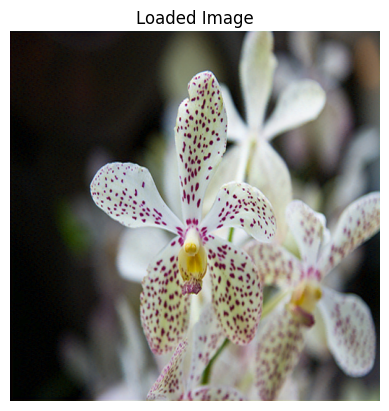

PSNR: 48.482238600774885


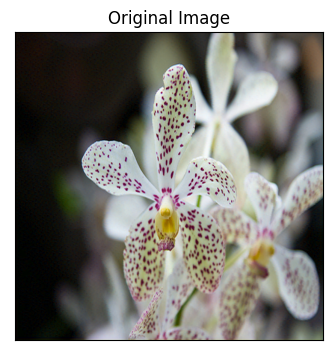

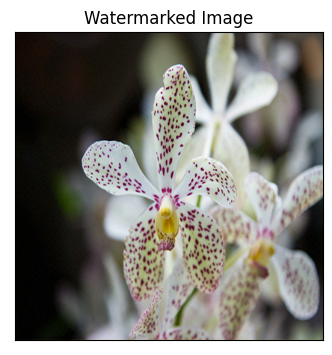

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


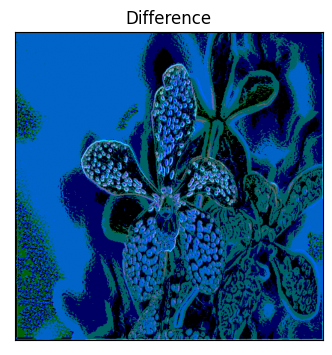

Message: 111010110101000001010111010011010100010000100111
Decoded: 000000000000000000000000000000000000000000000000
Bit Accuracy: 0.5208333333333334


In [24]:
# -------------------------------------------------------------------
# Main Code: Encode a watermark into an image and then decode it back.
# -------------------------------------------------------------------

# Load and prepare the image
img = Image.open("/home/azureuser/cloudfiles/code/Users/David.Fletcher/embedding_data/raw_watermarked_images/0_1ab8ea5ecaf859f061e099597d72b5ee_watermarked.png").convert('RGB')
img = img.resize((512, 512), Image.BICUBIC)

# Display the loaded image
plt.imshow(img)
plt.axis('off')  # Hide axis
plt.title("Loaded Image")
plt.show()

# Convert image for processing
img_pt = default_transform(img).unsqueeze(0).to(device)

# Create message: set random_msg to True for a random message; otherwise, use a fixed message.
random_msg = False
if random_msg:
    msg_ori = torch.randint(0, 2, (1, params.num_bits), device=device).bool()  # b x k
else:
    msg_ori = torch.Tensor(str2msg("111010110101000001010111010011010100010000100111")).unsqueeze(0)
msg_ori = msg_ori.to(device)  # Ensure message is on the same device as img_pt
msg = 2 * msg_ori.type(torch.float) - 1  # Convert to {-1, 1}

# Encode the watermark into the image using the encoder with JND module
img_w = encoder_with_jnd(img_pt, msg)
clip_img = torch.clamp(UNNORMALIZE_IMAGENET(img_w), 0, 1)
clip_img = torch.round(255 * clip_img) / 255 
clip_img = transforms.ToPILImage()(clip_img.squeeze(0).cpu())

# Compute PSNR between the original and watermarked images
psnr_value = peak_signal_noise_ratio(np.array(img), np.array(clip_img))
print(f"PSNR: {psnr_value}")

# Plot the Original Image
plt.figure(figsize=(4, 4))
plt.grid(False)
plt.xticks([])
plt.yticks([])
plt.title("Original Image")
plt.imshow(img)
plt.show()

# Plot the Watermarked Image
plt.figure(figsize=(4, 4))
plt.grid(False)
plt.xticks([])
plt.yticks([])
plt.title("Watermarked Image")
plt.imshow(clip_img)
plt.show()

# Plot the Difference between images (amplify threshold for visualization)
diff = np.abs(np.asarray(img).astype(int) - np.asarray(clip_img).astype(int)) / 255 * 100
plt.figure(figsize=(4, 4))
plt.grid(False)
plt.xticks([])
plt.yticks([])
plt.title("Difference")
plt.imshow(diff, cmap='hot')
plt.show()

# Decode the watermark from the watermarked image using the decoder from our earlier model
ft = decoder(default_transform(clip_img).unsqueeze(0).to(device))
decoded_msg = ft > 0.5  # Thresholding to get binary message  ###CAHNGED BY DF
accs = (~torch.logical_xor(decoded_msg, msg_ori))  # Bitwise comparison

# Print the original message, the decoded message, and the bit accuracy
print(f"Message: {msg2str(msg_ori.squeeze(0).cpu().numpy())}")
print(f"Decoded: {msg2str(decoded_msg.squeeze(0).cpu().numpy())}")
print(f"Bit Accuracy: {accs.sum().item() / params.num_bits}")


### Display the numerical difference for both images

In [25]:
pixel_diff = np.abs(np.asarray(img).astype(float) - np.asarray(clip_img).astype(float))
print("Max difference:", pixel_diff.max())
print("Mean difference:", pixel_diff.mean())


Max difference: 4.0
Mean difference: 0.6348902384440104


# Detect the watermark
### Load and Detect Watermark with the detection function



In [31]:


ckpt_path = "/home/azureuser/cloudfiles/code/Users/David.Fletcher/ost-embedding-research/Detector/ckpt/hidden_replicate.pth"
detected_bits = detect_watermark("/home/azureuser/cloudfiles/code/Users/David.Fletcher/embedding_data/raw_watermarked_images/0_1ab8ea5ecaf859f061e099597d72b5ee_watermarked.png", ckpt_path)
print("Detected Watermark Bits:", detected_bits)

mildchange_bits = detect_watermark("/home/azureuser/cloudfiles/code/Users/David.Fletcher/embedding_data/bitmask_1_images/0_1ab8ea5ecaf859f061e099597d72b5ee_watermarked.png", ckpt_path)
print("Detected Watermark Bits:", mildchange_bits)

mildchange_bits = detect_watermark("/home/azureuser/cloudfiles/code/Users/David.Fletcher/embedding_data/bitmask_2_images/0_1ab8ea5ecaf859f061e099597d72b5ee_watermarked.png", ckpt_path)
print("Detected Watermark Bits:", mildchange_bits)

mildchange_bits = detect_watermark("/home/azureuser/cloudfiles/code/Users/David.Fletcher/embedding_data/bitmask_3_images/0_1ab8ea5ecaf859f061e099597d72b5ee_watermarked.png", ckpt_path)
print("Detected Watermark Bits:", mildchange_bits)

mildchange_bits = detect_watermark("/home/azureuser/cloudfiles/code/Users/David.Fletcher/embedding_data/bitmask_4_images/0_1ab8ea5ecaf859f061e099597d72b5ee_watermarked.png", ckpt_path)
print("Detected Watermark Bits:", mildchange_bits)

mildchange_bits = detect_watermark("/home/azureuser/cloudfiles/code/Users/David.Fletcher/embedding_data/bitmask_5_images/0_1ab8ea5ecaf859f061e099597d72b5ee_watermarked.png", ckpt_path)
print("Detected Watermark Bits:", mildchange_bits)

mildchange_bits = detect_watermark("/home/azureuser/cloudfiles/code/Users/David.Fletcher/embedding_data/bitmask_6_images/0_1ab8ea5ecaf859f061e099597d72b5ee_watermarked.png", ckpt_path)
print("Detected Watermark Bits:", mildchange_bits)

mildchange_bits = detect_watermark("/home/azureuser/cloudfiles/code/Users/David.Fletcher/embedding_data/bitmask_7_images/0_1ab8ea5ecaf859f061e099597d72b5ee_watermarked.png", ckpt_path)
print("Detected Watermark Bits:", mildchange_bits)

void_bits = detect_watermark("/home/azureuser/cloudfiles/code/Users/David.Fletcher/embedding_data/bitmask_8_images/0_1ab8ea5ecaf859f061e099597d72b5ee_watermarked.png", ckpt_path)
print("Detected Watermark Bits:", void_bits)

#### IF NO WATERMARK, RETURNS NOTHING

/tmp/ipykernel_5338/109830047.py:76: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(ckpt_path, map_location=device)['encoder_decoder']


Detected Watermark Bits: 111010110101000001010111010011010100010000100111
Detected Watermark Bits: 111010110101000001010111010011010100010000100111
Detected Watermark Bits: 111010110101000001010111010011010100010000100111
Detected Watermark Bits: 111010110101000001010111010011010100010000100111
Detected Watermark Bits: 111010110101000001010111011011010100010000100111
Detected Watermark Bits: 111010111111000001010111000011010100000001100111
Detected Watermark Bits: 111000000101000001010111000001111100100001000110
Detected Watermark Bits: 111000010101000101110111100100111100100001000110
Detected Watermark Bits: 110000010001100101010101001000011010001001001111


### Display the similarity metrics

In [21]:
!pip install pytorch-fid

In [27]:
import os
import tempfile
import numpy as np
import matplotlib.pyplot as plt
from skimage.metrics import structural_similarity as ssim
from skimage.metrics import peak_signal_noise_ratio as psnr

# Convert images to NumPy arrays
img_np = np.array(img)
clip_img_np = np.array(clip_img)

# Compute SSIM and PSNR
ssim_value = ssim(img_np, clip_img_np, channel_axis=2)
psnr_value = psnr(img_np, clip_img_np)

print("SSIM:", ssim_value)
print("PSNR:", psnr_value)

# Compute FID using pytorch-fid (if installed)
try:
    from pytorch_fid import fid_score
    # Create temporary directories to save images
    with tempfile.TemporaryDirectory() as dir1, tempfile.TemporaryDirectory() as dir2:
        original_path = os.path.join(dir1, "img.png")
        watermarked_path = os.path.join(dir2, "img.png")
        img.save(original_path)
        clip_img.save(watermarked_path)
        fid_value = fid_score.calculate_fid_given_paths(
            [dir1, dir2],
            batch_size=50,
            device=device,
            dims=2048
        )
    print("FID:", fid_value)
except ImportError:
    print("pytorch-fid not installed; skipping FID computation.")

# -----------------------------
# Watermark Detection Metrics
# -----------------------------

# Convert the watermark messages to NumPy boolean arrays
decoded_bits = decoded_msg.squeeze(0).cpu().numpy().astype(bool)
original_bits = msg_ori.squeeze(0).cpu().numpy().astype(bool)

total_bits = len(original_bits)
num_errors = np.sum(decoded_bits != original_bits)
bit_error_rate = num_errors / total_bits

# Compute false positive rate (FPR) and false negative rate (FNR)
false_positives = np.sum((decoded_bits == True) & (original_bits == False))
false_negatives = np.sum((decoded_bits == False) & (original_bits == True))
true_positives = np.sum((decoded_bits == True) & (original_bits == True))
true_negatives = np.sum((decoded_bits == False) & (original_bits == False))

fpr = false_positives / (false_positives + true_negatives) if (false_positives + true_negatives) > 0 else 0.0
fnr = false_negatives / (false_negatives + true_positives) if (false_negatives + true_positives) > 0 else 0.0

print("Bit Error Rate:", bit_error_rate)
print("False Positive Rate:", fpr)
print("False Negative Rate:", fnr)



SSIM: 0.9961461999075333
PSNR: 48.482238600774885


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.69it/s]


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.51it/s]

FID: 0.2932049754537296
Bit Error Rate: 0.4791666666666667
False Positive Rate: 0.0
False Negative Rate: 1.0
